In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import statsmodels as sm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

df=pd.read_csv("/kaggle/input/insurance/insurance.csv")
df_org=df

In [ ]:
df.head(10)

**Showing basic statistical details statistical details**

In [ ]:
df.describe(include='all')

In [ ]:
sns.distplot(df['charges'])

1. Notice that there are no missing values
2. The values of charges column for percentile above 75% varies drastically. Meaning there are some entries where the charges are hefty.The probability distribution plot shows very low tails on the extreme right side. Lets explore more on this.


In [ ]:
#Taking the 99th percentile value and filtering the dataset to show entries above the 99th percentile
q=df['charges'].quantile(0.99)
#print(q)
df_out=df[(df['charges']>q)]
df_out.describe(include='all')

The above dataset reveals a few interpretations
1. People who have been charged hefty amounts are all smokers.
2. All of the entries have BMI index above 30 which is considered obese.
3. The mean age of these people are 50. Meaning older people are charged more

Lets come up with a few hypothesis here.
1. Smokers are charged more
2. Higher the BMI higher the charges
3. older the people more the charges
4. Gender doesn't play a role in charges
5. more number of children more the charges
6. Region does not play a role

In [ ]:
#Removing outlier data(99 percentile)
df_nonout=df[df['charges']<q]
sns.distplot(df_nonout['charges'])
df_nonout.reset_index(drop='True')
df_nonout.describe(include='all')

Lets encode all the categorical values for both original data and data without outlier.

In [ ]:
#df_nonout.info()
a=df_nonout._get_numeric_data()
print(a.columns.values)
l=df_nonout.select_dtypes(include=['object'])
print(l.columns.values)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#sex
le = LabelEncoder()
le.fit(df_nonout.sex.drop_duplicates()) 
df_nonout.sex = le.transform(df_nonout.sex)
# smoker or not
le.fit(df_nonout.smoker.drop_duplicates()) 
df_nonout.smoker = le.transform(df_nonout.smoker)
#region
le.fit(df_nonout.region.drop_duplicates()) 
df_nonout.region = le.transform(df_nonout.region)
print(df_nonout.head(10))

In [ ]:
from sklearn.preprocessing import LabelEncoder

#sex
le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)
# smoker or not
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)
#region
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)
print(df.head(10))

In [ ]:
f,ax=plt.subplots(2,3, sharey=False,figsize=(15,8))
ax[0][0].scatter(df_nonout['age'],df_nonout['charges'])
ax[0][0].set_title('age')
ax[0][1].scatter(df_nonout['bmi'],df_nonout['charges'])
ax[0][1].set_title('bmi')
ax[0][2].scatter(df_nonout['smoker'],df_nonout['charges'])
ax[0][2].set_title('smoker')
ax[1][0].scatter(df_nonout['region'],df_nonout['charges'])
ax[1][0].set_title('region')
ax[1][1].scatter(df_nonout['sex'],df_nonout['charges'])
ax[1][1].set_title('sex')
ax[1][2].scatter(df_nonout['children'],df_nonout['charges'])
ax[1][2].set_title('children')
plt.show()

From the above graphs we can conclude that
1. Age and smoker play a role in charges (hypothesis 1 and 3)
2. Gender and region doesn't play a role (hypothesis 4 and 6)

But we dont see a linear relationship in children and BMI
Lets see the correlation of independant variables to dependant variable

In [ ]:
df_nonout.corr()['charges'].sort_values()


We see Smoker is the highest correlated variable.While age is mildly correlated.
Region, sex, children and bmi does not show any correlation
Lets dive deep into BMI and children
we'll classify BMI between 18.5 to 25 as healthy and rest as unhealthy.

In [ ]:
df_nonout.loc[(df_nonout['bmi'] >=18.5) & (df_nonout['bmi'] <=25), 'health'] = 'healthy'  
df_nonout.loc[(df_nonout['bmi'] <18.5) | (df_nonout['bmi'] >25), 'health'] = 'unhealthy'
df_nonout.describe(include='all')

Notice that 82% of people in the data set are unhealthy.

In [ ]:
f,ax=plt.subplots(1,2, sharey=False,figsize=(15,8))
sns.boxplot(y="health", x="charges", data =  df_nonout , orient="h", palette = 'magma',ax=ax[0])
ax[0].set_title('health')
sns.boxplot(y="children", x="charges", data =  df_nonout , orient="h", palette = 'magma',ax=ax[1])
ax[1].set_title('children')

The above boxplots show charges has variability dependant on BMI and number of children.
Lets prove this statistically with hypothesis testing

# Hypothesis testing

In [ ]:
# Test for difference in variability for sex

from scipy import stats
df_anova = df_nonout[['charges','sex']]
grps = pd.unique(df_anova.sex.values)
d_data = {grp:df_anova['charges'][df_anova.sex == grp] for grp in grps}
#print(d_data)
F, p = stats.f_oneway(d_data[0], d_data[1])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

As observed above sex is not a significant variable

In [ ]:
# Test for difference in variability for bmi

from scipy import stats
df_anova = df_nonout[['charges','health']]

grps = pd.unique(df_anova.health.values)
d_data = {grp:df_anova['charges'][df_anova.health == grp] for grp in grps}

F, p = stats.f_oneway(d_data['healthy'], d_data['unhealthy'])#, d_data[2] )#, d_data[3], d_data[4], d_data[5])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

Statistically health condition plays a significant role. There is only 0.04% chance that variability in charges for healthy and unhealthy individuals will be same. which means there is a significant difference.

In [ ]:
# Test for difference in variability for children

from scipy import stats
df_anova = df_nonout[['charges','children']]
grps = pd.unique(df_anova.children.values)
d_data = {grp:df_anova['charges'][df_anova.children == grp] for grp in grps}
#print(d_data)
F, p = stats.f_oneway(d_data[0], d_data[1], d_data[2] , d_data[3], d_data[4], d_data[5])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

Number of children also play significant roles.

In [ ]:
# Test for difference in variability for children

from scipy import stats
df_anova = df_nonout[['charges','region']]
grps = pd.unique(df_anova.region.values)
d_data = {grp:df_anova['charges'][df_anova.region == grp] for grp in grps}
#print(d_data)
F, p = stats.f_oneway(d_data[0], d_data[1], d_data[2] , d_data[3])
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

region does not play significant role.

Lets standardize independant variables.

In [ ]:
#lets encode health column too for future reference.
le.fit(df_nonout.health.drop_duplicates()) 
df_nonout.health = le.transform(df_nonout.health)

df_xstand=df_nonout.drop(['charges'],axis=1)
x_cols=df_xstand.columns.values

scaler=StandardScaler()
scaler.fit(df_xstand)
x_scaled=scaler.transform(df_xstand)
df_xstand = pd.DataFrame(data=x_scaled, columns=x_cols)
print(df_xstand.head(10))

Now lets see which variables among the independant variables are multicollinear.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#we declare a variable where we put all features where we want to check for multicollinearity
#since health column is a derived column from bmi lets drop bmi
variables =df_nonout.drop(['charges'],axis=1)
# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally to include names so it is easier to explore the result
vif["Features"] = variables.columns
print(vif)

Notice that bmi variable has high inflation factor (above 10). This is because health is derived from bmi. Lets drop bmi and check.The ideal value is around 5 or less.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#we declare a variable where we put all features where we want to check for multicollinearity
#since health column is a derived column from bmi lets drop bmi
variables =df_nonout.drop(['charges','sex','region','bmi'],axis=1)
# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally to include names so it is easier to explore the result
vif["Features"] = variables.columns
print(vif)

All the variables are showing less inflation factor (<5) which means the variables dont have a correlation among each other.

To summarise:
1. smoker
2. age
3. children
4. health(BMI)
are the variables which are significant

Lets fit a linear regression and see the summary.

# Statsmodels on original data

This data is not treated for outlier and is not standardized

In [ ]:
#fitting regression on original data without outlier treatment.

df.loc[(df['bmi'] >=18.5) & (df['bmi'] <=25), 'health'] = 'healthy'  
df.loc[(df['bmi'] <18.5) | (df['bmi'] >25), 'health'] = 'unhealthy'
df.describe(include='all')
le.fit(df.health.drop_duplicates()) 
df.health = le.transform(df.health)

from statsmodels.regression.linear_model import OLS

y_org=df['charges']
x_org=df.drop(['charges'],axis=1)
x_org=add_constant(x_org)
result=OLS(y_org,x_org).fit()
result.summary()

Lets understand some statistical measures here.
1. R squared - show how much the independant variables define the variability of charges.
   here the variables explains almost 75% of the variability. Not bad.
   The problem with R squared value is it it doesn't account for how significant the variables in the model      is.
   
2. Adjusted R squared - modified version of R-squared that has been adjusted for the number of predictors in    the model. Gives a measure of how pure the model is. The adjusted R-squared increases only if the new term    improves the model more than would be expected by chance. It decreases when a predictor improves the model    by less than expected by chance.
   adjusted R-squared is used to compare the goodness-of-fit for regression models.
   our values are almost close to R squared which shows that model is not diluted with unnecessary variables.
   
3. F statistics - Gives overall significance of the model. Used to compare models. Even though p value          associated might be low the f scores between two models determine overall quality. Higher the F score        greater the significance.
 
4. Durbin-watson : Shows if there is autocorrelation. Linear regression works best when the data points are      random and does not have seasonal trends.
   value 2- indicates there is no autocorrelation . less than 1 or greater than 3 is a matter of concern and    other type of models should be considered.


Notice that the R- squared and adj R squared are different. F statistic is significant and high. 

Coming to signifance of Variables.
We see that sex and health is insignificant variables.
Now lets see the model with Significant variables

In [ ]:
y_org1=df['charges']
x_org1=df.drop(['charges','sex','region','bmi'],axis=1)
x_org1=add_constant(x_org1)
result=OLS(y_org1,x_org1).fit()
result.summary()

Notice that R2 and adj R2 is very close. F statistics has increased. There are no insignificant variables (above 0.05)

But R values have decreased. We have kept the derived column Health in the analysis. Lets drop health and try with BMI.

In [ ]:
y_org1=df['charges']
x_org1=df[['age','smoker','bmi','children']]
x_org1=add_constant(x_org1)
result=OLS(y_org1,x_org1).fit()
result.summary()

The r2 and adj r2 are equal to the first model. So bmi is a better variable than health to explain the variability of charges. F statistics has significantly increased from the first model.
Lets see which model has lesser error when prediction is done

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Split the variables with an 80-20 split and some random state
# To have the same split always random_state = 365
x_train, x_test, y_train, y_test = train_test_split(x_org, y_org, test_size=0.2, random_state=365)
x_train.reset_index(drop=True)
y_train.reset_index(drop=True)
x_test.reset_index(drop=True)
y_test.reset_index(drop=True)
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)
y_hat_train = reg.predict(x_train)
print("------Train R2 value-----")
print(reg.score(x_train,y_train))
print("------Test R2 value-----")
print(reg.score(x_test,y_test))
print("-----Mean error of Train---")
q=abs(y_train-y_hat_train)
sns.distplot(y_train-y_hat_train)
print(q.mean())
print("-----Mean % error of train---")
q=((abs(y_train-y_hat_train))/(y_train))*100
print(q.mean())
y_hat_test = reg.predict(x_test)
print("-----Mean error of Test---")
q=abs(y_test-y_hat_test)
print(q.mean())
print("-----Mean % error of Test---")
q=((abs(y_test-y_hat_test))/(y_test))*100
print(q.mean())

# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same

This shows the model is under-fitting. Lets try the next model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Split the variables with an 80-20 split and some random state
# To have the same split always random_state = 365
x_train, x_test, y_train, y_test = train_test_split(x_org1, y_org1, test_size=0.2, random_state=365)
x_train.reset_index(drop=True)
y_train.reset_index(drop=True)
x_test.reset_index(drop=True)
y_test.reset_index(drop=True)

reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)
y_hat_train = reg.predict(x_train)
print("------Train R2 value-----")
print(reg.score(x_train,y_train))
print("------Test R2 value-----")
print(reg.score(x_test,y_test))
print("-----Mean error of Train---")
q=abs(y_train-y_hat_train)
sns.distplot(y_train-y_hat_train)
print(q.mean())
print("-----Mean % error of train---")
q=((abs(y_train-y_hat_train))/(y_train))*100
print(q.mean())
y_hat_test = reg.predict(x_test)
print("-----Mean error of Test---")
q=abs(y_test-y_hat_test)
print(q.mean())
print("-----Mean % error of Test---")
q=((abs(y_test-y_hat_test))/(y_test))*100
print(q.mean())
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same

notice that the mean error has decreased slightly for the second model

# Statsmodels for processed Data 

Outliers and standardization is done.

P.S: The standardization takes care of the insignificant variables. So even if we keep the insignificant variable in the model the R values wont differ by much.

In [ ]:
from statsmodels.regression.linear_model import OLS

y=df_nonout['charges']
y=y.values.reshape(-1,1)

x=df_xstand

x=add_constant(x)

result=OLS(y,x).fit()
result.summary()

The above linear regression is fitted for all variables. 
Notice that p values for sex and region are higher than signicance level (0.05)
so we need to drop those variables and fit the regression again.

In [ ]:
from statsmodels.regression.linear_model import OLS

y1=df_nonout['charges']
y1=y1.values.reshape(-1,1)

x1=df_xstand.drop(['sex','region'],axis=1)

x1=add_constant(x1)

result=OLS(y1,x1).fit()
result.summary()

Notice that there is no change in R2 and adj R2 values even after removing insignicant variables for standardized data. After standardization the insignificant columns dont play a role in R2. The F statistics has increased

Now lets keep only significant variables.

In [ ]:
from statsmodels.regression.linear_model import OLS

y1=df_nonout['charges']
y1=y1.values.reshape(-1,1)

x1=df_xstand[['age','smoker','health','children']]

x1=add_constant(x1)

result=OLS(y1,x1).fit()
result.summary()

Lets drop Health and try with BMI

In [ ]:
from statsmodels.regression.linear_model import OLS

y1=df_nonout['charges']
y1=y1.values.reshape(-1,1)

x1=df_xstand[['age','smoker','bmi','children']]

x1=add_constant(x1)

result=OLS(y1,x1).fit()
result.summary()

The R2 values have reduced when compared to the original data. The F statistics are almost the same.
Lets predict values for standardized data set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Split the variables with an 80-20 split and some random state
# To have the same split always random_state = 365
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=365)
x_train.reset_index(drop=True)
#y_train.reset_index(drop=True)
x_test.reset_index(drop=True)
#y_test.reset_index(drop=True)

reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)
y_hat_train = reg.predict(x_train)
print("------Train R2 value-----")
print(reg.score(x_train,y_train))
print("------Test R2 value-----")
print(reg.score(x_test,y_test))
print("-----Mean error of Train---")
q=abs(y_train-y_hat_train)
sns.distplot(y_train-y_hat_train)
print(q.mean())
print("-----Mean % error of train---")
q=((abs(y_train-y_hat_train))/(y_train))*100
print(q.mean())
y_hat_test = reg.predict(x_test)
print("-----Mean error of Test---")
q=abs(y_test-y_hat_test)
print(q.mean())
print("-----Mean % error of Test---")
q=((abs(y_test-y_hat_test))/(y_test))*100
print(q.mean())
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Split the variables with an 80-20 split and some random state
# To have the same split always random_state = 365
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=365)
x_train.reset_index(drop=True)
#y_train.reset_index(drop=True)
x_test.reset_index(drop=True)
#y_test.reset_index(drop=True)

reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)
y_hat_train = reg.predict(x_train)
print("------Train R2 value-----")
print(reg.score(x_train,y_train))
print("------Test R2 value-----")
print(reg.score(x_test,y_test))
print("-----Mean error of Train---")
q=abs(y_train-y_hat_train)
sns.distplot(y_train-y_hat_train)
print(q.mean())
print("-----Mean % error of train---")
q=((abs(y_train-y_hat_train))/(y_train))*100
print(q.mean())
y_hat_test = reg.predict(x_test)
print("-----Mean error of Test---")
q=abs(y_test-y_hat_test)
print(q.mean())
print("-----Mean % error of Test---")
q=((abs(y_test-y_hat_test))/(y_test))*100
print(q.mean())
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same

## Summary statistics

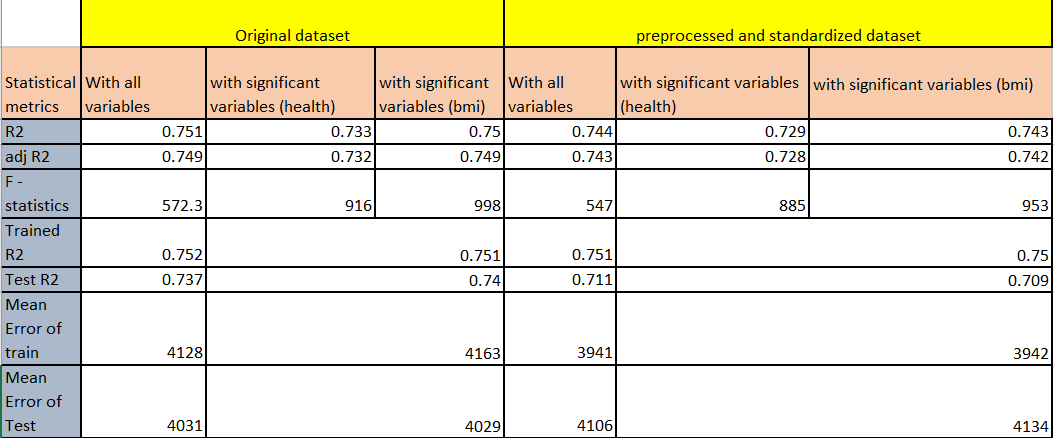

To summarize,

The key indicators are Smoker, age, bmi and children.
So far the best model is the original data with the above mentioned predictors. This model has the least value for mean error for test.